In [38]:
from collections import *
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import *
from scipy.stats import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

<br>

# Motivation: Density Estimation
---

Say we have a collection of data points $X$, where each row is a data point $x_i$. We would like to model the data generating process that generate these points. This is called **density estimation**.

Density estimation is useful any time you need some kind of probability distribution to fuel some other model that is based on it. For instance, if you want to estimate how many people take the bus in average, you are interested in modeling the probability that a person comes to the bus station. To do so, you might have to fit some data that lists all the coming and going at the bus stations.

<br>

### Latent variables

Some of those distributions can be more easily described by introducing **latent variables, i.e. unobserved data that underlies the distribution of X**. For instance, if we take the problem of the modeling of arrival of people at the bus station, we can easily imagine two distributions, based on the type of passengers:

* People $z_1 = (1\;0)^T$ who go or come back to work
* People $z_2 = (0\;1)^T$ who wander around for other business

Let us call $Z$ the random variable that represents the type of people. We could try to model two probability distributions for the two classes of people. Our overall probability distribution is then the mixture (composition) of both:

&emsp; $p(X) = \sum_{z \in Z} p(x,z) = \sum_{z \in Z} p(x|z) p(z)$

Where $p(x|z)$ can have different shapes, different type of distribution, depending on the value of $z$.

<br>

### Why latent variables?

Latent variables can serve several purposes. One is simply **pure mathematical convenience**: it might be easier to model (i.e. approximate) a distribution as a mixture of several gaussian as it would be to try to find a custom function for it.

But these latent variables could also **represent some underlying data, or confounder** we have not access to be would be interested by. For instance, we might suspect that behind the two clusters of people that use the bus, one is made of people that travel for business reasons. If we later get some information regarding a given category of passengers, we are able to better reproduct their behavior. For instance, in the case of the bus, if we can later correlate the probability of $z_1$ (travel for work) with the time of the day, we can able to do better predictions.

Finally, it can also be used for **data compression**. If we are able to show that some N-dimensional data is in fact generated by an underlying D-dimensional latent vector, with $D \ll N$, we can sumarize our data using this D-dimensional vector plus some noise if need be.

<br>

### Difficulties of dealing with latent variables

Say we are interested in modeling the distribution of data $p(X|\theta)$ where $\theta$ are the parameters of our distribution, and we decomposed our distribution as a mixture of distributions $p_z = p(x|z)$:

&emsp; $p(x|\theta) = \sum_z p(x|z,\theta) p(z|\theta)$

To model the distribution, we might following the Maximum Likelihood approach, which consists in maximizing the likelihood of seeing the data $X$ with respect to the parameters $\theta$. If we assume that all $x_i$ of the *design matrix* $X$ are independent and identically distributed, the classical trick consists in maximizing the logarithm of the likelihood instead:

&emsp; $\theta^* = \underset{\theta}{\operatorname{argmax}} p(X|\theta) = \underset{\theta}{\operatorname{argmax}} \log p(X|\theta) = \underset{\theta}{\operatorname{argmax}} \log \prod_i p(x_i|\theta) =\underset{\theta}{\operatorname{argmax}} \sum_i \log p(x_i|\theta)$

For exponential form distributions, such as Gaussians, the logarithm makes it very easy to get a *closed form* solution. But for mixture distributions, even mixture of exponetial distributions, the sum inside the logarithm forbids us to get any closed form solution:

&emsp; $\theta^* = \underset{\theta}{\operatorname{argmax}} \sum_i \log \sum_z p(x_i,z|\theta)$

Note that this does not forbid us to deal with these latent variables with approximate optimization techniques, such as gradient descent.

<br>

# Expectation-Maximization (EM) algorithm
---

The idea of the EM algorithm is a algorithm to optimize the distribution $p(x|\theta) = \sum_z p(x,z|\theta)$ when the joint distribution $p(x,z|\theta)$ is easier to optimize than the marginal distribution $p(x|\theta)$.

This kind of situation typically arise when $p(x|\theta)$ is a mixture of exponential distributions. In such cases, the EM algorithm acts as a way to *move the logarithm inside the sum*, which allows to find a closed form.

<br>

### The decomposition

The idea of the EM algorithm is to decompose the logarithm of the likelihood in such a way that it can be more easily optimized.

&emsp; $\log p(X,Z|\theta) = \log p(Z|X,\theta) + \log P(X|\theta) \implies \log p(X|\theta) = \log p(X,Z|\theta) - \log p(Z|X,\theta)$

If we introduce a distribution $q(Z)$, we can further write:

&emsp; $\log p(X|\theta) = \sum_Z q(Z) (\log p(X,Z|\theta) - \log q(Z) + \log q(Z) - \log p(Z|X,\theta))$

&emsp; $\log p(X|\theta) = \sum_Z q(Z) \log \frac{p(X,Z|\theta)}{q(Z)} - \sum_Z q(Z) \log \frac{p(Z|X,\theta)}{q(Z)}$

&emsp; $\log p(X|\theta) = \mathcal{L}(q,\theta) + D_{KL}(q \Vert p)$

$D_{KL}(q \Vert p)$ is the KL divergence between $q$ and $p$. This quantity is always positive and is equal to zero only when $q$ is equal to $p$, that is when $q(Z)$ is equal to $p(Z|X,\theta)$, the distribution of the latent variable based on the inputs (1). This means that $\mathcal{L}(q,\theta)$ **is a lower bound for** $p(X|\theta)$.

*(1) which by the way is a kind of "reverse" probability distribution, since $Z$ is most likely the cause of $X$*

<br>

### The E and M steps

The algorithm proceeds to increase $\mathcal{L}(q,\theta)$, the lower bound to $p(X|\theta)$, in two steps, the E step and the M step.

In the **E (Expectation) step** consists in fixing $\theta$ and modifying $q(Z)$ to increase $\mathcal{L}(q,\theta)$. This is equivalent to make $q$ being equal to $p(Z|X,\theta)$ to make the KL divergence go to zero. In other words, it consists in adjusting the distribution of the latent variable to fit the data with the current parameters $\theta$.

In the **M (Maximization) step** consits in fixing $q(Z)$ and modifying $\theta$ to increase $\mathcal{L}(q,\theta)$. Since $q(Z)$ is fixed, this is equivalent to maximizing the expectation of $p(X,Z|\theta)$:

&emsp; $\theta^* = \underset{\theta}{\operatorname{argmax}} \mathcal{L}(q,\theta) = \underset{\theta}{\operatorname{argmax}} \sum_Z q(Z) \log p(X,Z|\theta) = \underset{\theta}{\operatorname{argmax}} E_{Z}[\log p(X,Z|\theta)]$

In other words, it consists in maximizing the expectation to see the data $X$ joint with $Z$, based on the distribution of $Z$. The key is that thanks to this manipulation, the logarithm is now applied on the joint distribution $p(X,Z|\theta)$. If this joint distribution is exponential (like the Gaussian), this optimization can be done in *closed form*.

<br>

### Why does it work?

Both steps consits in increasing $\mathcal{L}(q,\theta)$, the lower bound of $p(X|\theta)$. These steps will converge to a maximum of $\mathcal{L}(q,\theta)$. The last E-step will reduce the KL divergence to zero, leading to $\mathcal{L}(q,\theta) = p(X|\theta)$.

* During the E-step, the lower bound is increased by making the KL diverge equal to zero, making it equal to the likelihood of the data
* During the M-step, the lower bound is increased by playing with $\theta$, and the likelihood will increase by at least as much, since the KL divergence can only increase

The converge is garanteed unless the likelihood goes to infinity. This might happen, for instance, for a component of a gaussian mixture containing just a single point, in which case the likelihood can go to infinity by just decreasing the variance to zero.

<br>

### Extensions

The **Generalized EM algorithm** can be applied in cases where $\mathcal{L}(q,\theta)$ is too hard to optimize with respect to $\theta$ with a *closed form*. In such a case, we can use methods such as **gradient descent** to maximize $\mathcal{L}$.

We can similarly generate the E-step, in case we cannot reduce the KL divergence to zero easily. In such cases, we can parameterize the probability distribution $q(Z)$ to $q(Z|\alpha)$, and replace the E-step by minimization using gradient descent once again.

In both cases, the same convergence garanties as the EM algorithm still hold, because the mechanism which consists in maximizing the lower bound of the likelihood of the data $\mathcal{L}$ still proceeds the same.

<br>

# Application to Gaussian Mixture models
---

Let us go back to the representation of the frequency of people arriving at a bus station.

<br>

### Creation of a Toy Dataset

We will assume that the frequency of people coming to the bus station depends on the time, and follows a distribution that looks like this:

* One pike around 9 o'clock for people going to work
* One pike around 19 o'clock for people coming back from work
* And otherwise a distribution centered around 14 o'clock with large variance

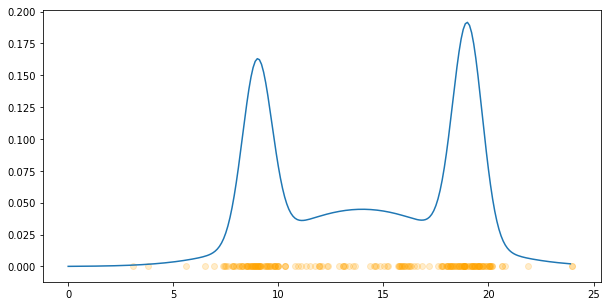

In [39]:
class Gaussian:
    def __init__(self, mu: float, sigma: float):
        self.mu = mu
        self.sigma = sigma
    
    def __call__(self, xs):
        return np.exp(- (xs - self.mu) ** 2 / (2 * self.sigma ** 2)) / math.sqrt(2 * math.pi * self.sigma**2)

    def sample(self, size: int):
        return np.random.normal(loc=self.mu, scale=self.sigma)

class Mixture:
    def __init__(self, components):
        self.probs = []
        self.pdfs = []
        for prob, component in components:
            self.probs.append(prob)
            self.pdfs.append(component)
    
    def __call__(self, xs):    
        ys = np.zeros(shape=len(xs))
        for prob, component in zip(self.probs, self.pdfs):
            ys += prob * component(xs)
        return ys
    
    def sample(self, size: int):
        idx = np.random.choice(len(self.pdfs), size=size, p=self.probs)
        return np.array([self.pdfs[i].sample(1) for i in idx])

mixture = Mixture([
    (0.25, Gaussian(9., 0.7)),
    (0.45, Gaussian(14., 4.)),
    (0.30, Gaussian(19, 0.7))])


train_xs = mixture.sample(200)
train_xs = np.clip(train_xs, 0., 24., out=train_xs)

ts = np.arange(0, 24, 0.1)
plt.figure(figsize=(10,5))
plt.plot(ts, mixture(ts))
plt.scatter(train_xs, np.zeros(len(train_xs)), color='orange', alpha=0.2)
plt.show()

We now have a data set of 200 points that each represent the hour at which a passenger took the bus.

<br>

### Modeling as Gaussian Mixtures

We look at the data points and decide to model this as a mixture of 3 independant gaussian, with probability $\pi_k$ means $\mu_k$ and variance $\sigma_k^2$. We denote $\theta$ as being all these parameters. We encode the gaussian member-ness as the latent variable $Z$ with one-of-K (one-hot) encoding:

&emsp; $p(x|\theta) = \sum_{k=1}^{k \le 3} p(x,z_k=1|\theta) = \sum_{k=1}^{k \le 3} \pi_k \mathcal{N}(x|\mu_k,\sigma_k^2)$

&emsp; $p(z_k=1) = \pi_k$
&emsp; $\sum_k \pi_k = 1$
&emsp; $p(z) = \prod_k \pi_k^{z_k}$

&emsp; $p(x,z|\theta) = \prod_k \pi_k^{z_k} \mathcal{N}(x|\mu_k,\sigma_k^2)^{z_k}$
&emsp; *(the power will select the right component)*

If we now consider each point $x_i$ of the data set as independent and identically distributed:

&emsp; $\log p(X|\theta) = \sum_i \log p(x_i|\theta) = \sum_i \log \sum_k \pi_k \mathcal{N}(x_i|\mu_i,\sigma_i^2)$

&emsp; $\log p(X,Z|\theta) = \sum_i \log p(x_i, z_i|\theta) = \sum_i \sum_k \log \big ( \pi_k^{z_{ik}} \mathcal{N}(x_i|\mu_k,\sigma_k^2)^{z_{ik}} \big ) = \sum_i \sum_k z_{ik} \big ( \log \pi_k + \log \mathcal{N}(x_i|\mu_k,\sigma_k^2) \big )$

Although the normal distribution is an exponential distribution, the formula $p(X|\theta)$ is intractable, as the logarithm cannot go into the summation over $k$, but the formula for the joint distribution with the latent variables $p(X,Y|\theta)$ is tractable. This is the typical use case for the EM algorithm.

<br>

### E-step for Gaussian Mixtures

The E-step consists in adjusting our distribution $q(Z)$ over the latent variables to maximize the functional $\mathcal{L}(q,\theta)$, or alternatively, to minimize the KL divergence with the distribution $p(Z|X,\theta)$.

We can use the Bayes's formula to compute this quantity for each individual data point:

&emsp; $\displaystyle \gamma_k(x) = p(z_k|x,\theta) = \frac{p(x|z_k,\theta)p(z_k|\theta)}{p(x|\theta)} = \frac{p(x|z_k,\theta)p(z_k|\theta)}{\sum_{k'} p(x|z_{k'},\theta)p(z_{k'}|\theta)} = \frac{\pi_k \mathcal{N}(x|\mu_k,\sigma_k^2)}{\sum_{k'} \pi_{k'} \mathcal{N}(x|\mu_{k'},\sigma_{k'}^2)}$

We call this quantity the **responsibility** that component $k$ takes for explaining the data point $x$. The E-step consists in computing this responsibility, with $\theta$ fixed, for each component of each latent variable of each data point.

<br>

### M-step for Gaussian Mixtures

The M-step consits in maximizing the expected value of the joint log likelihood $\log p(X,Z|\theta)$ with respect to $\theta$:

&emsp; $\theta^* = \underset{\theta}{\operatorname{argmax}} E_{Z}[\log p(X,Z|\theta)]$
&emsp; with
&emsp; $\log p(X,Z|\theta) = \sum_i \sum_k z_{ik} \big ( \log \pi_k + \log \mathcal{N}(x|\mu_k,\sigma_k^2) \big )$

We could develop the expected value as $\sum_Z q(Z) \log p(X,Z|\theta)$ with $q(Z) = \prod_i \gamma_k(x_i)$, but the easiest way to evaluate the expected value is to see that the value of $z_nk$ will be zero, but for the selected variables, and each of these are independent. Consequently, the value of $z_nk$ will be replaced by $\gamma_k(x_n)$ since it is the expected value of that variable:

&emsp; $E_{Z}[\log p(X,Z|\theta)] = \mathcal{Q}(\theta, \theta^\text{old}) = \mathcal{L}(q,\theta) = \sum_i \sum_k \gamma_k(x_i) \big ( \log \pi_k + \log \mathcal{N}(x_i|\mu_k,\sigma_k^2) \big )$

Note that the dependency on $\theta^\text{old}$ comes from the fact that we *fixed* the responsibilities $\gamma_k(x_i)$ in this expression, and these $\gamma_k(x_i)$ represent the quantity $q(Z)$ that depends on the previous value of $\theta$. Now, we want to maximize this quantity with respect to $\theta = (\mu_k, \sigma_k^2, \pi_k)$.

<br>

### Unrolling the computations

We have to unroll the computations in order to find the maximizing parameters:

&emsp; $\displaystyle \mathcal{Q} = \sum_i \sum_k \gamma_k(x_i) \big ( \log \pi_k - \frac{1}{2 \sigma_k^2} (x_i - \mu_k)^2 - \log \sigma_k \big ) + const$

Because the formula is so simple, we can consider the derivative of each parameter independently. We can start with $\mu_k$ parameters:

&emsp; $\displaystyle \frac{\partial \mathcal{Q}}{\partial \mu_k} = - \frac{1}{\sigma_k^2} \sum_i \gamma_k(x_i) (x_i - \mu_k) = 0$
$\implies \displaystyle \mu_k = \frac{1}{N_k} \sum_k \gamma_k(x_i) x_i$
&emsp; where
&emsp; $N_k = \sum_k \gamma_k(x_i)$

Now we turn to $\pi_k$, for which we have to build a Langragian to encode the constraint $\sum_k \pi_k = 1$:

&emsp; $\mathcal{L} = \mathcal{Q} - \lambda (\sum_k \pi_k - 1)$
$\displaystyle \implies \frac{\partial \mathcal{L}}{\partial \pi_k} = \sum_i \frac{\gamma_k(x_i)}{\pi_k} - \lambda = 0$
$\displaystyle \implies \pi_k = \frac{\sum_i \gamma_k(x_i)}{\lambda}$
$\displaystyle \implies \pi_k = \frac{N_k}{N}$ (because of $\sum_k \pi_k = 1$)

Finally, we deal similarly with $\sigma_k$:

&emsp; $\displaystyle \frac{\partial \mathcal{Q}}{\partial \sigma_k} = \sum_i \gamma_k(x_i) \big ( - \frac{1}{\sigma_k} + \frac{1}{\sigma_k^3} (x_i - \mu_k)^2 \big ) = 0$
$\displaystyle \implies \sigma_k^2 = \frac{1}{N_k} \sum_i \gamma_k(x_i) (x_i - \mu_k)^2$

To summarize, the M-step consists on doing the following updates:

&emsp; $\displaystyle \pi_k = \frac{N_k}{N}$
&emsp; $\displaystyle \mu_k = \frac{1}{N_k} \sum_k \gamma_k(x_i) x_i$
&emsp; $\displaystyle \sigma_k^2 = \frac{1}{N_k} \sum_i \gamma_k(x_i) (x_i - \mu_k)^2$

In [40]:
# TODO - implementation

<br>

### Other approches: PyTorch (1)

&emsp; $\log p(X|\theta) = \sum_i \log p(x_i|\theta) = \sum_i \log \sum_k \pi_k \mathcal{N}(x_i|\mu_i,\sigma_i^2)$

**todo**

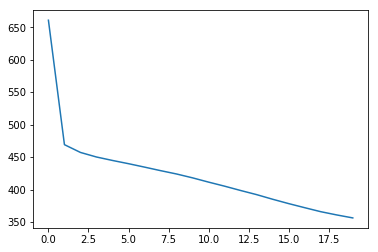

tensor([ 8.9658,  9.9372, 18.9718], grad_fn=<MulBackward0>)
tensor([0.2629, 0.2176, 0.5194], grad_fn=<SoftmaxBackward>)
tensor([0.8453, 8.6676, 4.3991], grad_fn=<ExpBackward>)


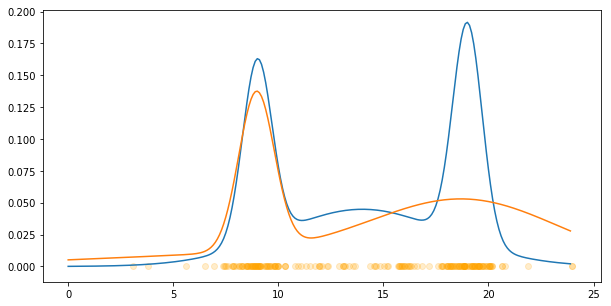

In [100]:
class MixtureModel(nn.Module):
    def __init__(self, nb_gaussians: int):
        super().__init__()
        self.nb_gaussians = nb_gaussians
        self.mus = nn.Parameter(torch.FloatTensor(nb_gaussians))
        self.pis = nn.Parameter(torch.FloatTensor(nb_gaussians))
        self.vars = nn.Parameter(torch.FloatTensor(nb_gaussians))
        nn.init.uniform_(self.mus, 0., 24.)
        nn.init.ones_(self.vars)
        nn.init.ones_(self.pis)
    
    def forward(self, xs):
        batch_size = xs.shape[0]
        probs = nn.Softmax(dim=-1)(self.pis)
        mus = self.mus
        variances = torch.exp(self.vars)
        return sum (self.mixture_loss_fct(xs[i], probs, mus, variances) for i in range(batch_size))
    
    def mixture_loss_fct(self, x, probs, mus, variances):
        components = []
        for k in range(self.nb_gaussians):
            pi_k = probs[k]
            mu_k = self.mus[k]
            var_k = variances[k]
            contribution = pi_k * torch.exp(-(x[0] - mu_k) ** 2 / (2 * var_k)) / torch.sqrt(var_k)
            components.append(contribution)
        return - torch.log(sum(components))
    
    def to_pdf(self):
        self.eval()
        probs = nn.Softmax(dim=-1)(self.pis).detach().numpy()
        mus = self.mus.detach().numpy()
        variances = torch.exp(self.vars).detach().numpy()
        
        components = []
        for i in range(self.nb_gaussians):
            components.append((probs[i], Gaussian(mus[i], variances[i])))
        return Mixture(components)
        

model = MixtureModel(nb_gaussians=3)
model.train()
        
X = torch.FloatTensor(train_xs).unsqueeze(-1)
ds = data.TensorDataset(X)
loader = data.DataLoader(ds, shuffle=True, batch_size=100)
optimizer = optim.SGD(model.parameters(), lr=1e-2)

losses = []
for _ in range(20):
    episode_loss = 0.
    for x in loader:
        loss = model(x[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        episode_loss += loss.item()
    losses.append(episode_loss)

plt.plot(losses)
plt.show()

print(1 * model.mus)
print(nn.Softmax(dim=-1)(model.pis))
print(torch.exp(model.vars))

mixture_approx = model.to_pdf()

ts = np.arange(0, 24, 0.1)
plt.figure(figsize=(10,5))
plt.plot(ts, mixture(ts))
plt.plot(ts, mixture_approx(ts))
plt.scatter(train_xs, np.zeros(len(train_xs)), color='orange', alpha=0.2)
plt.show()

<br>

# Continuous latent variables
---

* PCA
* Auto encoders for MNIST
* Can it work for other things like classification or regression? does it even make sense? p(y|x)